In [1]:
import os
import logging
from pathlib import Path

from dotenv import dotenv_values
import pickle
import wandb
import numpy as np
import torch
import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

from exrep.model import LocalRepresentationApproximator, init_target
from exrep.registry import load_tensor, get_artifact, save_tensor, load_entry

if 'notebooks' in os.getcwd():
    os.chdir("../")

local_config = dotenv_values(".env")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

random_state = 42

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "attribution_downstream",
        "num_clusters": 80,
    },
    # reinit=True,
    # save_code=True,
)

device = "cuda:6"

wandb: Currently logged in as: nhathcmus to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [2]:
run_cfg = wandb.Api().run("explain-representation/8qn2q1m2").config
run.config.update({'training': run_cfg['training'], 'target': run_cfg['target']})
model_name = "mocov3-resnet50"
artifact = get_artifact(
    base_name="imagenet",
    phase="surrogate",
    identifier=model_name,
    alias='v18',
    wandb_run=run,
)
weights = torch.load(
    artifact.get_entry(f"explainer-{run.config.num_clusters}.pt").download(),
    device
)
model = LocalRepresentationApproximator(
    local_dim=weights['query_encoder.weight'].shape[1],
    # repr_dim=weights['key_encoder.weight'].shape[1],
    repr_dim=None,
    output_dim=weights['query_encoder.weight'].shape[0],
    temperature=run_cfg['loss']['temp_student'],
    use_key_encoder=run_cfg['surrogate']['use_key_encoder'],
    device=device,
)
model.load_state_dict(weights)

/tmp/ipykernel_2887838/705537197.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(


<All keys matched successfully>

In [3]:
%load_ext autoreload
%autoreload 2

from scripts.train_surrogate import load_data_from_runs
from exrep.viz import plot_dendrogram, get_cluster_children, viz_clusters, get_cluster_leaves

In [4]:
train_dataloader, val_dataloader, data_sizes = load_data_from_runs(run, device=device)

target_model = init_target(**run.config.target, device=device)

/blue/thai/hoangx/projects/explain-representation/exrep/registry.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path, map_location=map_locati

In [5]:
# next(iter(train_dataloader))
train_embeddings, train_labels, train_encoding = [], [], []
for batch in train_dataloader:
    train_labels.extend(batch['label'])
    train_encoding.extend(batch['inputs'])
    with torch.inference_mode():
        train_embeddings.extend(target_model.embed(batch['image'].to(device)).detach().cpu())

test_embeddings, test_labels, test_encoding = [], [], []
for batch in val_dataloader:
    test_labels.extend(batch['label'])
    test_encoding.extend(batch['inputs'])
    with torch.inference_mode():
        test_embeddings.extend(target_model.embed(batch['image'].to(device)).detach().cpu())

In [6]:
train_embeddings = torch.stack(train_embeddings)
train_labels = torch.stack(train_labels)
train_encoding = torch.stack(train_encoding)

print(train_embeddings.shape, train_labels.shape, train_encoding.shape)

test_embeddings = torch.stack(test_embeddings)
test_labels = torch.stack(test_labels)
test_encoding = torch.stack(test_encoding)

print(test_embeddings.shape, test_labels.shape, test_encoding.shape)

torch.Size([2000, 2048]) torch.Size([2000]) torch.Size([2000, 80])
torch.Size([1000, 2048]) torch.Size([1000]) torch.Size([1000, 80])


In [7]:
target_classifier = LogisticRegression(C=1, fit_intercept=False).fit(train_embeddings, train_labels)
target_score = target_classifier.score(test_embeddings, test_labels)
print(f"Target model test score: {target_score}")

target_train_labels = target_classifier.predict(train_embeddings)
target_test_labels = target_classifier.predict(test_embeddings)

with torch.inference_mode():
    surrogate_train_embeds = model.encode_query(train_encoding.to(device)).detach().cpu().numpy()
    surrogate_test_embeds = model.encode_query(test_encoding.to(device)).detach().cpu().numpy()

surrogate_classifier = LogisticRegression(C=1).fit(surrogate_train_embeds, target_train_labels)
surrogate_train_score = surrogate_classifier.score(surrogate_train_embeds, target_train_labels)
surrogate_test_score = surrogate_classifier.score(surrogate_test_embeds, target_test_labels)

best_classifier = LogisticRegression(C=1).fit(train_encoding, target_train_labels)
best_train_score = best_classifier.score(train_encoding, target_train_labels)
best_test_score = best_classifier.score(test_encoding, target_test_labels)

print(f"Surrogate test score: {surrogate_test_score}, best test score: {best_test_score}")
print(f"Surrogate train score: {surrogate_train_score}, best train score: {best_train_score}")

Target model test score: 0.819
Surrogate test score: 0.611, best test score: 0.611
Surrogate train score: 0.707, best train score: 0.712


In [8]:
import shap

def surrogate_repr_pred_fn(x: np.array):
    """Function to predict the (prediction of original model) class of a input x (in the local encoding space).
    
    Args:
        x (np.array): Input array of shape (n_samples, n_features)
        
    Returns:
        preds (np.array): Array of shape (n_samples, n_classes) with the predicted class probabilities
    """
    x_tensor = torch.tensor(x, dtype=torch.float32, device=device)
    with torch.inference_mode():
        surrogate_embed = model.encode_query(x_tensor).detach().cpu().numpy()
    return surrogate_classifier.predict_proba(surrogate_embed)

shap_explainer = shap.KernelExplainer(surrogate_repr_pred_fn, np.zeros((1, train_encoding.shape[1])))
shap_values = shap_explainer.shap_values(test_encoding.numpy(), nsamples=1000) 
shap_values.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = array([-0.02762678, -0.02390416])
INFO:shap:phi = array([-0.02801936, -0.02804376])
INFO:shap:phi = array([0.05555471, 0.01084408])
INFO:shap:phi = array([-0.00098133, -0.01511264])
INFO:shap:phi = array([ 0.00535773, -0.03329831])
INFO:shap:phi = array([-0.01786553, -0.0269817 ])
INFO:shap:phi = array([ 0.01950533, -0.01922392])
INFO:shap:phi = array([ 0.01433311, -0.02157122])
INFO:shap:phi = array([0.02229818, 0.00188076])
INFO:shap:phi = array([-0.03872786,  0.02412537])
INFO:shap:phi = array([0.0362802 , 0.11636851])
INFO:shap:phi = array([0.00086188, 0.01384479])
INFO:shap:phi = array([-0.00580152,  0.01791914])
INFO:shap:phi = array([0.00779829, 0.00717786])
INFO:shap:phi = array([-0.0016774 , -0.02121407])
INFO:shap:phi = array([-0.02179166, -0.0171151 ])
INFO:shap:phi = array([-0.01269394,  0.00549028])
INFO:shap:phi = array([0.02569615, 0.00021041])
INFO:shap:phi = array([-0.01401455,  0.00032376])
INFO:shap:phi = array([-0.01848

(1000, 80, 20)

In [ ]:
# with torch.inference_mode():
#     surrogate_prototypes = model.encode(key=torch.from_numpy(classifier.coef_).to(device, dtype=torch.float32), normalize=True)
#     surrogate_train_logits = surrogate_train_embeds @ surrogate_prototypes.T / model.temperature
#     surrogate_train_probs = torch.softmax(surrogate_train_embeds @ surrogate_prototypes.T / model.temperature, dim=1)
#     kl_train_loss = torch.nn.functional.kl_div(
#         torch.log_softmax(surrogate_train_logits, dim=1), 
#         torch.from_numpy(train_original_logits).to(device),
#         reduction='batchmean',
#         log_target=True,
#     )
#     ce_train_loss = torch.nn.functional.cross_entropy(
#         surrogate_train_logits,
#         torch.from_numpy(train_original_probs).to(device),
#     )

#     surrogate_test_logits = surrogate_test_embeds @ surrogate_prototypes.T / model.temperature
#     surrogate_test_probs = torch.softmax(surrogate_test_embeds @ surrogate_prototypes.T / model.temperature, dim=1)
#     kl_loss = torch.nn.functional.kl_div(
#         torch.log_softmax(surrogate_test_logits, dim=1), 
#         torch.from_numpy(test_original_logits).to(device),
#         reduction='batchmean',
#         log_target=True,
#     )
#     ce_loss = torch.nn.functional.cross_entropy(
#         surrogate_test_logits,
#         torch.from_numpy(test_original_probs).to(device),
#     )
# kl_loss, ce_loss, kl_train_loss, ce_train_loss

(tensor(1.2667, device='cuda:3', dtype=torch.float64),
 tensor(2.2868, device='cuda:3', dtype=torch.float64),
 tensor(1.2864, device='cuda:3', dtype=torch.float64),
 tensor(2.1154, device='cuda:3', dtype=torch.float64))

In [ ]:
# def learn_bias(surrogate_logits, original_logits, n_iter=100, lr=0.2):
#     bias = torch.randn(surrogate_logits.shape[1], device=surrogate_logits.device, requires_grad=True)
#     optimizer = torch.optim.Adam([bias], lr=lr)
#     surrogate_logits = torch.tensor(surrogate_logits, requires_grad=True)
#     original_logits = torch.tensor(original_logits, requires_grad=True)
#     for _ in range(n_iter):
#         loss = torch.nn.functional.cross_entropy(
#             surrogate_logits + bias,
#             torch.softmax(original_logits, dim=1)
#         )
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # logger.info(f"Loss: {loss.item()}")
#     bias = bias - bias.min()
#     return bias

# b = learn_bias(surrogate_train_logits, torch.from_numpy(train_original_logits).to(device))

/tmp/ipykernel_256427/2162876122.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  surrogate_logits = torch.tensor(surrogate_logits, requires_grad=True)
/tmp/ipykernel_256427/2162876122.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_logits = torch.tensor(original_logits, requires_grad=True)


In [ ]:
# kl_train_loss_with_bias = torch.nn.functional.kl_div(
#     torch.log_softmax(surrogate_train_logits + b, dim=1), 
#     torch.from_numpy(train_original_logits).to(device),
#     reduction='batchmean',
#     log_target=True,
# )
# ce_train_loss_with_bias = torch.nn.functional.cross_entropy(
#     surrogate_train_logits + b,
#     torch.from_numpy(train_original_probs).to(device),
# )
# kl_test_loss_with_bias = torch.nn.functional.kl_div(
#     torch.log_softmax(surrogate_test_logits + b, dim=1), 
#     torch.from_numpy(test_original_logits).to(device),
#     reduction='batchmean',
#     log_target=True,
# )
# ce_test_loss_with_bias = torch.nn.functional.cross_entropy(
#     surrogate_test_logits + b,
#     torch.from_numpy(test_original_probs).to(device),
# )
# kl_test_loss_with_bias, ce_test_loss_with_bias, kl_train_loss_with_bias, ce_train_loss_with_bias, b

(tensor(1.1162, device='cuda:3', dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(2.1363, device='cuda:3', dtype=torch.float64, grad_fn=<DivBackward1>),
 tensor(1.1371, device='cuda:3', dtype=torch.float64, grad_fn=<DivBackward0>),
 tensor(1.9662, device='cuda:3', dtype=torch.float64, grad_fn=<DivBackward1>),
 tensor([1.5053, 1.0876, 0.4429, 0.7236, 0.8911, 1.9336, 1.0165, 0.8929, 0.0000,
         0.8635, 0.9676, 0.7969, 0.5752, 1.2712, 0.9000, 1.0568, 0.1907, 0.7835,
         0.9143, 0.1876], device='cuda:3', grad_fn=<SubBackward0>))

In [ ]:
# W_r is (n_output_dim, n_concepts)
# W_h is (n_classes, 
# z = W_r @ x + b_r
# y = W_h @ z + b_h

# y = W_h @ (W_r @ x + b_r) + b_h
# y = (W_h @ W_r) @ x + W_h @ b_r + b_h 

In [46]:
class_of_interest = 0
weight_matrix = (surrogate_prototypes @ weights['query_encoder.weight']).detach().cpu().numpy()
w = weight_matrix[class_of_interest]
w

array([-0.00750654,  0.18827158,  0.0825977 , -0.09313332, -0.1486488 ,
        0.18861797,  0.10312222, -0.05825114,  0.03321671,  0.18071505,
        0.31577113,  0.22268571, -0.06472655, -0.00114891, -0.00413281,
       -0.03167045, -0.01875549,  0.01314385, -0.02275135, -0.05588555,
       -0.03987815, -0.06011763, -0.11971533, -0.04144117, -0.04730426,
        0.00816663,  0.06624279,  0.02646448,  0.02392489,  0.06162746,
       -0.03533496, -0.05212297,  0.00439849, -0.05089075, -0.07168689,
       -0.08358577, -0.01543046,  0.01477541, -0.02528204,  0.00301183,
       -0.08312719,  0.00609009, -0.01232483,  0.00448225,  0.00630058,
       -0.04960679,  0.01286714,  0.01961364, -0.04945298,  0.06796314,
       -0.00060112,  0.01313794,  0.36092073,  0.01245663, -0.02899911,
        0.00602047,  0.0067529 ,  0.01931424,  0.00187607, -0.05092889,
        0.06534994, -0.01231031, -0.08798386, -0.09576164, -0.02124438,
        0.0376915 , -0.07088746,  0.02701864, -0.02695056,  0.00

In [47]:
np.round(w[np.argsort(w)[::-1]],3)

array([ 0.361,  0.316,  0.223,  0.189,  0.188,  0.181,  0.103,  0.083,
        0.068,  0.066,  0.065,  0.062,  0.038,  0.033,  0.027,  0.026,
        0.024,  0.024,  0.02 ,  0.019,  0.015,  0.013,  0.013,  0.013,
        0.012,  0.012,  0.008,  0.007,  0.006,  0.006,  0.006,  0.005,
        0.004,  0.004,  0.003,  0.002,  0.001, -0.001, -0.001, -0.004,
       -0.008, -0.012, -0.012, -0.015, -0.019, -0.021, -0.023, -0.023,
       -0.025, -0.025, -0.027, -0.029, -0.029, -0.03 , -0.032, -0.035,
       -0.039, -0.04 , -0.041, -0.047, -0.049, -0.05 , -0.051, -0.051,
       -0.052, -0.056, -0.058, -0.06 , -0.065, -0.071, -0.072, -0.083,
       -0.084, -0.088, -0.093, -0.096, -0.12 , -0.149], dtype=float32)

In [48]:
indices = np.argsort(w)[:-6:-1]
indices, w[indices]
# np.where(w[0] > 0)[0]

(array([52, 10, 11,  5,  1]),
 array([0.36092073, 0.31577113, 0.22268571, 0.18861797, 0.18827158],
       dtype=float32))

In [9]:
clustering_pkl = load_entry(
    artifact_name="imagenet-1k-first-20-take-2000_clustering",
    file_name="agglomerative.pkl",
    wandb_run=run,
)
crops_dataset = datasets.load_from_disk(get_artifact(
    base_name="imagenet",
    phase="crops",
    wandb_run=run,
).download())
images_dataset = datasets.load_from_disk(get_artifact(
    base_name="imagenet",
    phase="images",
    wandb_run=run,
).download())
with open(clustering_pkl, "rb") as f:
    clustering = pickle.load(f)
dendograms = {}

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_crops:latest, 510.63MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:1.9
wandb: Downloading large artifact imagenet-1k-first-20-take-2000_images:latest, 367.90MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:0.6


In [10]:
offset = np.max(crops_dataset['train']['image_id']) + 1
crops_dataset['validation'] = crops_dataset['validation'].map(
    lambda x: {
        "image_id": [y + offset for y in x["image_id"]]
    },    
    batched=True,
    keep_in_memory=True,
)

combined_crops_dataset = datasets.concatenate_datasets([crops_dataset['train'], crops_dataset['validation']], axis=0)

Map:   0%|          | 0/4208 [00:00<?, ? examples/s]

In [11]:
combined_crops_dataset[0]

{'label': [13],
 'patches': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'boxes': [0.0, 221.0, 998.0, 606.0],
 'image_id': 0,
 'patch_index': 0}

In [241]:
# inspect single prediction
idx = 93
x = test_encoding[idx]
im = images_dataset['validation'][idx]
label = test_labels[idx]
original_label = target_classifier.predict(test_embeddings[idx].reshape(1, -1))[0]
surrogate_label = surrogate_classifier.predict(surrogate_test_embeds[idx].reshape(1, -1))[0]
print(f"Target model label: {original_label}, surrogate label: {surrogate_label}, true label: {label}")

# select the most important concepts
indices = np.argsort(-shap_values[idx, :, label])[:4]
shap_values[idx, indices, label], indices

Target model label: 11, surrogate label: 11, true label: 11


(array([0.73018524, 0.09137472, 0.06392759, 0.05128662]),
 array([17, 31, 74, 77]))

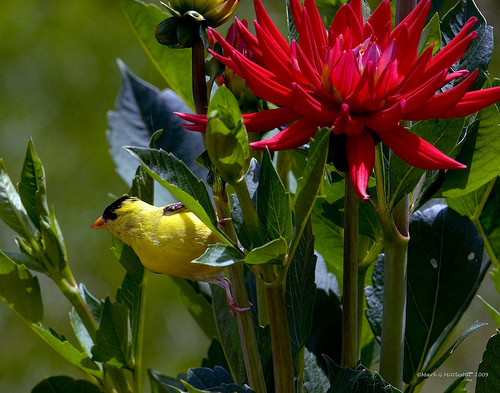

In [242]:
im['image']

In [183]:
def load_label_encoder(n_clusters):
    label_encoder_pkl = load_entry(
        f"label-encoder-{n_clusters}.pkl",
        base_name="imagenet",
        phase="local-encoding",
        identifier="agglomerative",
        wandb_run=run,
    )
    with open(label_encoder_pkl, "rb") as f:
        label_encoder = pickle.load(f)
    return label_encoder

In [244]:
label_encoder = load_label_encoder(run.config.num_clusters)
cluster_ids = label_encoder.inverse_transform(indices)
cluster_labels = get_cluster_leaves(cluster_ids, clustering)[0]
cluster_ids

array([23203, 23239, 23308, 23311])

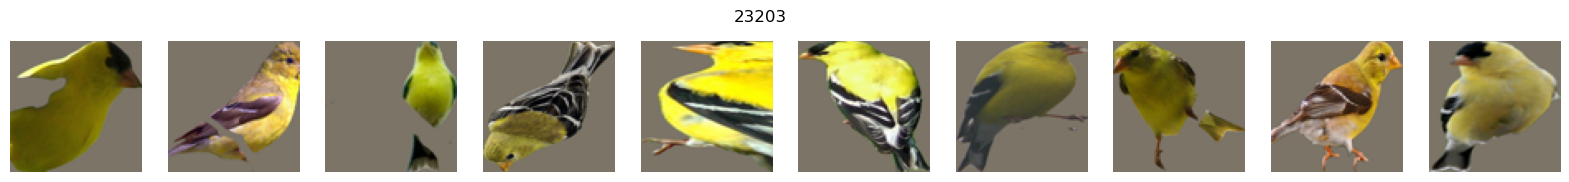

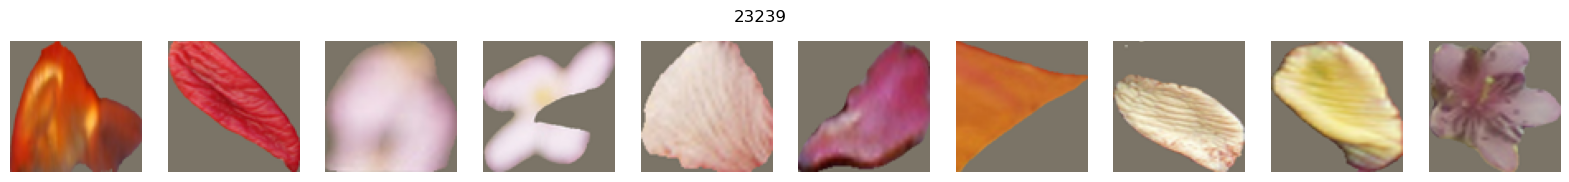

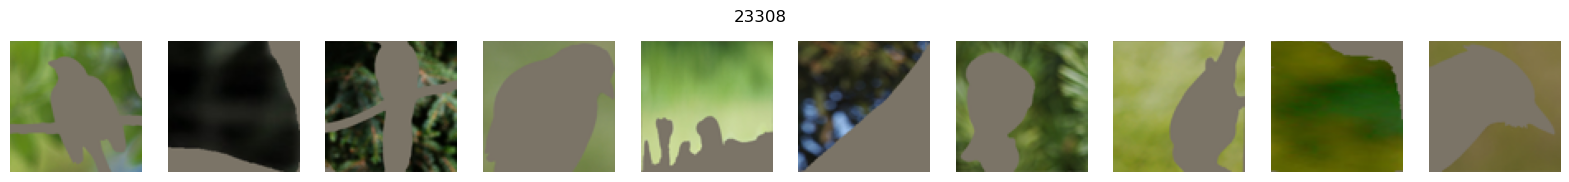

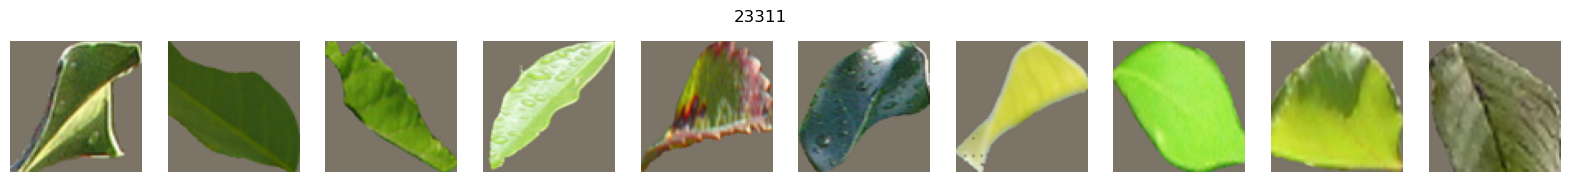

In [245]:
viz_clusters(cluster_ids, cluster_labels, combined_crops_dataset, preview_size=10, shuffle=True)

In [238]:
images_of_interest = images_dataset.filter(lambda x: x['label'] == 6, keep_in_memory=True)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

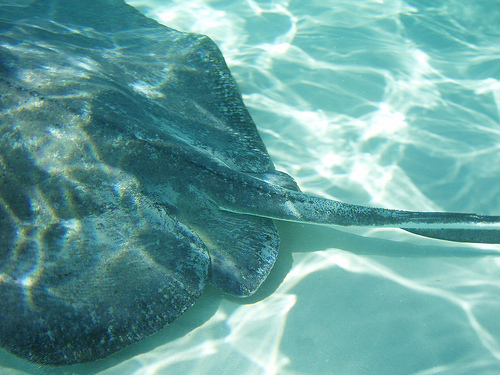

In [256]:
images_of_interest[55]['image']